# Simulating the Signal of a Gamma Detector

This IPython Notebook explains how to calculate the signal of a gamma detector using the pulse-height tally. 
It also shows how to create a realistic image of a detector simulation that takes into account the detector's intrinsic resolution.

In particular, this Notebook illustrates the following features:
* setting up a simulation of a gamma detector 
* defining a gamma source from a specific isotopic mixture
* reprocessing the simulation output to obtain a realistic pulse-height spectrum

In [94]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import openmc

from scipy.constants import Avogadro

## Setting up the Detector Model
In the following, we will set up a simplified model of a gamma scintillation detector. 
In front of this gamma detector, we will place two point sources:
* The first source will launch $10^{12}$ gamma particles with an energy of 200 keV per second toward the detector. 
* The second source simulates the emissions of 1 gram of Cs137.
Cs137 is a radioactive isotope that primarily emits gamma particles with an energy of 661.7 keV due to beta decay into Ba137_m1.
The Ba137_m1 releases gamma radiation to de-excite. In addition, this source is implemented as an isotropic source.

To obtain the emissions from an arbitrary isotopic source, OpenMC provides the `openmc.data.decay_photon_energy` feature, which returns the gamma radiation emitted during radioactive decay.

The pulse-height score is determined by the NaI crystal in the detector with the corresponding tally.

### Defining the Material

In [3]:
aluminum = openmc.Material()
aluminum.add_element('Al', 1)
aluminum.set_density('g/cm3', 2.7)

sodium_iodide = openmc.Material()
sodium_iodide.add_element('Na', 1)
sodium_iodide.add_element('I', 1)
sodium_iodide.set_density('g/cm3', 3.667)

aluminum_oxide = openmc.Material()
aluminum_oxide.add_nuclide('O16', 0.4) 
aluminum_oxide.add_element('Al', 0.6)
aluminum_oxide.set_density('g/cm3', 3.97)

iron = openmc.Material()
iron.add_element('Fe', 1)
iron.set_density('g/cm3', 7.874)

mats = openmc.Materials([aluminum, sodium_iodide, aluminum_oxide, iron])
mats.export_to_xml()

### Defining the Geometry

In [4]:
# Defining surfaces
c1 = openmc.ZCylinder(r=3.81)
c2 = openmc.ZCylinder(r=3.86)
c3 = openmc.ZCylinder(r=3.91)

z1 = openmc.ZPlane(z0=0.00)
z2 = openmc.ZPlane(z0=0.05)
z3 = openmc.ZPlane(z0=0.10)
z4 = openmc.ZPlane(z0=7.72)
z5 = openmc.ZPlane(z0=7.77)
z6 = openmc.ZPlane(z0=8.00)

s = openmc.Sphere(r=11, boundary_type='vacuum')

In [5]:
# Defining cells
sodium_iodide_crystal = openmc.Cell()
sodium_iodide_crystal.region = -c1 & -z4 & +z3
sodium_iodide_crystal.fill = sodium_iodide

aluminum_casing = openmc.Cell()
aluminum_casing.region = (+c2 & -c3 & -z4 & +z2) | (-c3 & -z2 & +z1)
aluminum_casing.fill = aluminum

oxide_layer = openmc.Cell()
oxide_layer.region = (+c1 & -c2 &-z4 & +z2) | (-c2 & -z3 & +z2)
oxide_layer.fill = aluminum_oxide

detector_back = openmc.Cell()
detector_back.region = -c3 & -z6 & +z4
detector_back.fill = iron

surrounding = openmc.Cell()
surrounding.region = -s & ~(-c3 & -z6 & +z1)

In [6]:
universe = openmc.Universe(cells=[sodium_iodide_crystal, aluminum_casing, oxide_layer, oxide_layer, detector_back, surrounding])
geometry = openmc.Geometry(universe)
geometry.export_to_xml()

The following shows the structure of the cylindrical detector. 

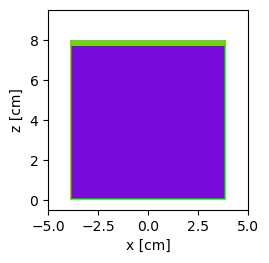

In [92]:
universe.plot(width=(10.0, 10.0), origin=(0.0, 0.0, 4.5), basis='xz', color_by='material')

### Defining the Sources
The definition of the first source is straightforward. 
Keep in mind that the energy in the sources is given in the unit of eV.

In [8]:
source_1 = openmc.Source()
source_1.space = openmc.stats.Point((0.0, 0.0, -10.0))
source_1.angle = openmc.stats.Monodirectional([0.0, 0.0, 1.0])
source_1.energy = openmc.stats.Discrete([800_000.0], [1.0])
source_1.strength = 1e12
source_1.particle = 'photon'

The definition of the second source is more extensive and makes use of the `openmc.data.decay_photon_energy` functionality.
The `openmc.data.decay_photon_energy` probability distribution for the different gamma energies, per second per atom.
Cs137 has a half-life of 30.17 years, while Ba137_m1 has a much shorter half-life of 2.55 minutes with a branching ratio of 0.946.
This implies that 94.6% of Cs137 decays into Ba137_m1. 

In the following, the decay scheme of Cs137 can be seen again (public domain).

<img src="images/cs137_decay.png" alt="Cs137_spectrum" width="300" />

We assume an equilibrium between Cs137 and Ba137_m1.
To calculate the equilibrium amounts of these isotopes, we use the relationship 

$\dfrac{T_{1/2}^{p}}{T_{1/2}^{c} \cdot b_{p,c}} = \dfrac{N_{A}^{p}}{N_{A}^{c}}$,

where $T_{1/2}^{p}$ is the half-life of the parent, $T_{1/2}^{c}$ is the half-life of the child, $b_{p,c}$ is the branching ratio, and $N_{A}^{p}$ and $N_{A}^{c}$ are the equilibrium amounts of the parent and child, respectively.

In [9]:
half_life_Cs137_seconds = 30.17 * 365 * 24 * 60 * 60
half_life_Ba137_m1_seconds = 2.55 * 60
branching_ratio = 0.946
fraction_atoms_Ba137_m1 = (half_life_Ba137_m1_seconds * branching_ratio) / half_life_Cs137_seconds

number_atoms_Ba137_m1 = (1/137) * Avogadro * fraction_atoms_Ba137_m1
number_atoms_Cs137 = (1/137) * Avogadro * (1-fraction_atoms_Ba137_m1)

In [10]:
openmc.config['chain_file'] = "./chain_simple.xml"

source_2_Cs137 = openmc.Source()
source_2_Cs137.space = openmc.stats.Point((-1.0, 0.0, 0.0))
source_2_Cs137.angle = openmc.stats.Isotropic()
source_2_Cs137.energy = openmc.data.decay_photon_energy("Cs137")
source_2_Cs137.particle = 'photon'
source_2_Cs137.strength = np.sum(openmc.data.decay_photon_energy("Cs137").p) * number_atoms_Cs137

source_2_Ba137_m1 = openmc.Source()
source_2_Ba137_m1.space = openmc.stats.Point((-1.0, 0.0, 0.0))
source_2_Ba137_m1.angle = openmc.stats.Isotropic()
source_2_Ba137_m1.energy = openmc.data.decay_photon_energy("Ba137_m1")
source_2_Ba137_m1.particle = 'photon'
source_2_Ba137_m1.strength = np.sum(openmc.data.decay_photon_energy("Ba137_m1").p) * number_atoms_Ba137_m1

### Defining the Settings

In [11]:
settings = openmc.Settings()
settings.particles = 10**4
settings.batches = 10
settings.photon_transport = True
settings.source = [source_1, source_2_Cs137, source_2_Ba137_m1]
settings.run_mode = 'fixed source'
settings.export_to_xml()

### Defining the Tallies
We obtain the values of the pulse-height tallies by utilizing an energy filter with 1000 bins of size 1 keV, ranging from 0 MeV to 1 MeV.

In [12]:
tallies = openmc.Tallies()

energy_bins = np.linspace(0, 1e6, 1001)
energy_filter = openmc.EnergyFilter(energy_bins)
cell_filter = openmc.CellFilter(sodium_iodide_crystal)

tally = openmc.Tally(name='pulse-height')
tally.filters = [cell_filter, energy_filter]
tally.scores = ['pulse-height']
tallies.append(tally)
tallies.export_to_xml()

## Running the Simulation

In [13]:
openmc.run("/home/cpf/Desktop/openmc/build/bin/openmc")

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

## Extracting the results
In a next step we want to extract and plot the results of the pulse height tally.

In [96]:
sp = openmc.StatePoint('statepoint.10.h5')
tally = sp.get_tally(name='pulse-height')
pulse_height_values = tally.get_values(scores=['pulse-height']).flatten()

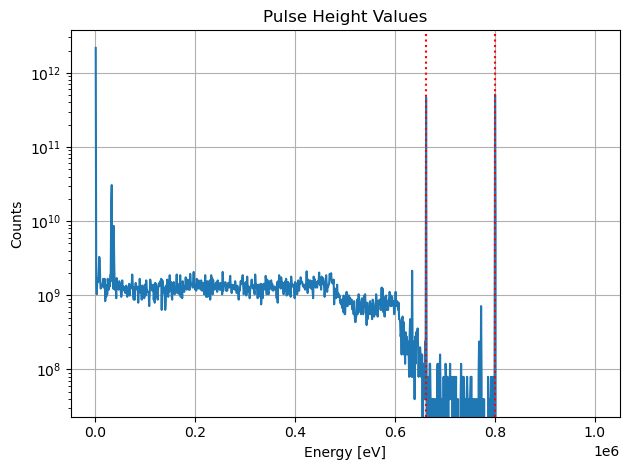

In [97]:
# we want to display the pulse-height value in the center of the bin
energy_bin_centers = energy_bins[1:] + 0.5 * (energy_bins[1] - energy_bins[0])

plt.figure()
plt.semilogy(energy_bin_centers, pulse_height_values)

# plot the strongest sources as vertical lines
plt.axvline(x=800_000, color="red", ls=":")     # source_1
plt.axvline(x=661_700, color="red", ls=":")     # source_2

plt.xlabel('Energy [eV]')
plt.ylabel('Counts')
plt.title('Pulse Height Values')
plt.grid(True)
plt.tight_layout()

At this moment, a few points can make things easier to understand:
* We have plotted red vertical lines at for the energies of the strongest sources in the spectrum - the 661.7 keV Cs137 line and the artificial 800 keV line. But also other characteristic peaks of a gamma spectrum can be seen.
* The prominent peak at the first pulse-height value, corresponding to 0 keV, indicates that particles have deposited no energy in the sodium-iodide crystal. This peak does not have a counterpart in real-life detector measurements, as no interaction implies no possibility of measurement. Consequently, we will exclude this peak in subsequent analyses.
* The current simulation statistics are not optimal and could benefit from simulating a substantially larger number of particles.
* In the illustrated example (despite the suboptimal statistics), peaks are displayed as narrow lines. However, in real-world experiments, these peaks are broadened due to the inherent detector resolution. In the next section, we present a method to post-process the pulse-height data to simulate realistic detector signals.

## Post processing the results
The intrinsic detector resolution is the result of several physical effects such as charge collection statistics or electronic noise.
Further it depends on the energy of the incoming particle. 
The resolution of a detector R(E) is given as the quotient of the full width at half maximum (FWHM) and the energy (E) of the incoming particle:

$R(E) = \frac{\mathrm{FWHM}(E)} {E}$

Usually, this is determined for a detector in several measurements with known sources, and then a function is fitted to these measured values. In this example we will use

$R(E) = \frac{a + b\sqrt{E+cE^{2}}}{E}$.

Further, we assume 

$a = 1000$ 

$b = 4$ 

$c = 0.0002$ 

In a next step, we can broaden the results of the pulse-height tallies according to this function.
The idea is to go through all the energy bins, determine the respective Gaussian function, and sample according to that.
Here we make use of the fact that for a Gaussian 

$\sigma(E) = \dfrac{\mathrm{FWHM}(E)}{2 \sqrt{2 \ln{2}}}$.

In [82]:
a, b, c = 1000, 4, 0.0002
number_broadening_samples = 1e6

def gauss(E, a=a, b=b, c=c):
    sigma = (a + b * (E + c * E**2)**0.5) / (2 * (2 * np.log(2))**0.5)
    return np.random.normal(loc=E, scale=sigma)

samples = np.random.choice(energy_bin_centers[1:], size=int(number_broadening_samples), p=pulse_height_values[1:]/np.sum(pulse_height_values[1:]))
broaded_pulse_height_values = gauss(samples)

broaded_spectrum, _ = np.histogram(broaded_pulse_height_values, bins=energy_bins)
renormalized_broaded_spectrum = broaded_spectrum / np.sum(broaded_spectrum) * np.sum(pulse_height_values[1:])

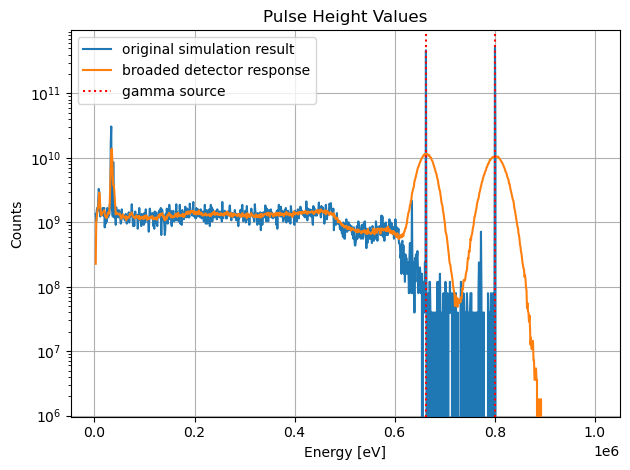

In [88]:
plt.figure()

plt.semilogy(energy_bin_centers[1:], pulse_height_values[1:], label="original simulation result")
plt.semilogy(energy_bin_centers[1:], renormalized_broaded_spectrum[1:], label="broaded detector response")

# plot the strongest sources as vertical lines
plt.axvline(x=800_000, color="red", ls=":", label="gamma source")     # source_1
plt.axvline(x=661_700, color="red", ls=":")                           # source_2

plt.legend()
plt.xlabel('Energy [eV]')
plt.ylabel('Counts')
plt.title('Pulse Height Values')
plt.grid(True)
plt.tight_layout()

## Current Limitations
There are currently still some limitations in the simulation. These will be addressed in the future:
* Some isotopes perform a beta+ decay before emitting a gamma. The resulting positron then annhilates with an electron, producing two 511 keV gamma particles that generate an annhilation peak in the detector. These 511 keV gamma particles have to be inserted manually as source.
* No summation peaks can be simulated yet.
* A comprehensive validation of this method will be published soon.